In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Paths
PROCESSED_PATH = r"D:\data-driven-stock-analysis\data\processed"
SUMMARY_PATH = r"D:\data-driven-stock-analysis\data\summary"

# Ensure output directory exists
os.makedirs(SUMMARY_PATH, exist_ok=True)

def calculate_metrics(df):
    # Ensure the date column exists and is sorted
    if 'date' not in df.columns:
        return None

    df = df.sort_values(by='date').copy()

    # Convert 'close' column to numeric
    df['close'] = pd.to_numeric(df['close'], errors='coerce')

    # Calculate daily returns
    df['daily_return'] = df['close'].pct_change()

    # Drop NaN values
    df.dropna(subset=['daily_return'], inplace=True)

    # Calculate summary metrics
    mean_return = df['daily_return'].mean()
    volatility = df['daily_return'].std()

    return df, mean_return, volatility

def process_all_stocks(input_folder, output_folder):
    summary_records = []

    for file in tqdm(os.listdir(input_folder), desc="Calculating Metrics"):
        if file.endswith(".csv"):
            symbol = file.replace(".csv", "")
            file_path = os.path.join(input_folder, file)

            try:
                df = pd.read_csv(file_path)

                result = calculate_metrics(df)
                if result is None:
                    print(f"Skipping {symbol}: missing or malformed data.")
                    continue

                df_metrics, avg_return, volatility = result

                # Save the updated DataFrame with daily_return to summary folder
                output_file = os.path.join(output_folder, f"{symbol}_metrics.csv")
                df_metrics.to_csv(output_file, index=False)

                # Store summary info for all stocks
                summary_records.append({
                    'symbol': symbol,
                    'average_return': avg_return,
                    'volatility': volatility,
                    'total_days': len(df_metrics)
                })

            except Exception as e:
                print(f"Error processing {symbol}: {e}")

    # Save summary CSV with all symbols
    summary_df = pd.DataFrame(summary_records)
    summary_df.sort_values(by='average_return', ascending=False, inplace=True)
    summary_df.to_csv(os.path.join(output_folder, "summary_metrics.csv"), index=False)
    print("\nSummary metrics saved.")

if __name__ == "__main__":
    print("Starting metric calculation...\n")
    process_all_stocks(PROCESSED_PATH, SUMMARY_PATH)
    print("\nAll done! Check the 'summary' folder.")


Starting metric calculation...



Calculating Metrics:  22%|██▏       | 13/58 [00:00<00:03, 14.78it/s]C:\Users\ALDO\AppData\Local\Temp\ipykernel_32816\115687804.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['daily_return'] = df['close'].pct_change()
Calculating Metrics:  86%|████████▌ | 50/58 [00:02<00:00, 35.94it/s]

Skipping sector_wise_returns: missing or malformed data.
Skipping top_10_gainers: missing or malformed data.


Calculating Metrics: 100%|██████████| 58/58 [00:02<00:00, 22.20it/s]

Skipping top_10_losers: missing or malformed data.
Skipping top_10_volatile_stocks: missing or malformed data.
Error processing top_5_cumulative_returns: 'close'

Summary metrics saved.

All done! Check the 'summary' folder.


In [3]:
import pandas as pd
import os
from glob import glob

# Path where your symbol CSVs are stored
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Read and combine all CSV files
all_files = glob(os.path.join(processed_folder, "*.csv"))

combined_data = []

for file in all_files:
    symbol = os.path.basename(file).replace(".csv", "")
    
    try:
        df = pd.read_csv(file)

        # Skip files that don't have both 'date' and 'close' columns
        if 'date' not in df.columns or 'close' not in df.columns:
            print(f" Skipping {symbol}. Missing 'date' or 'close' column.")
            continue

        df['symbol'] = symbol
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df[df['close'].notna()]  # Ensure 'close' is valid

        combined_data.append(df)

    except Exception as e:
        print(f" Error reading {symbol}: {e}")
        continue

# Check if any valid data was loaded
if not combined_data:
    print(" No valid data found in CSVs.")
else:
    # Merge all symbol data
    combined_df = pd.concat(combined_data, ignore_index=True)
    combined_df.sort_values(by=["symbol", "date"], inplace=True)

    # Calculate yearly return
    returns_df = combined_df.groupby('symbol').agg(
        start_price=('close', 'first'),
        end_price=('close', 'last')
    ).reset_index()

    returns_df['yearly_return_%'] = ((returns_df['end_price'] - returns_df['start_price']) / returns_df['start_price']) * 100

    # Top 10 best and worst performers
    top_10_gainers = returns_df.sort_values(by='yearly_return_%', ascending=False).head(10)
    top_10_losers = returns_df.sort_values(by='yearly_return_%', ascending=True).head(10)

    # Save to CSVs
    gainers_path = os.path.join(processed_folder, "top_10_gainers.csv")
    losers_path = os.path.join(processed_folder, "top_10_losers.csv")

    top_10_gainers.to_csv(gainers_path, index=False)
    top_10_losers.to_csv(losers_path, index=False)

    print(" Top 10 Gainers saved to:", gainers_path)
    print(top_10_gainers[['symbol', 'start_price', 'end_price', 'yearly_return_%']])

    print("\n Top 10 Losers saved to:", losers_path)
    print(top_10_losers[['symbol', 'start_price', 'end_price', 'yearly_return_%']])


 Skipping sector_wise_returns. Missing 'date' or 'close' column.
 Skipping top_10_gainers. Missing 'date' or 'close' column.
 Skipping top_10_losers. Missing 'date' or 'close' column.
 Skipping top_10_volatile_stocks. Missing 'date' or 'close' column.
 Skipping top_5_cumulative_returns. Missing 'date' or 'close' column.
 Top 10 Gainers saved to: D:\data-driven-stock-analysis\data\processed\top_10_gainers.csv
        symbol  start_price  end_price  yearly_return_%
47       TRENT      2059.10    6652.80       223.092613
8          BEL       139.20     280.85       101.760057
30         M&M      1537.40    3012.95        95.976974
5   BAJAJ-AUTO      5016.45    9481.65        89.011153
9   BHARTIARTL       925.30    1569.30        69.599049
35   POWERGRID       199.55     336.95        68.854924
10        BPCL       170.68     285.85        67.477150
20  HEROMOTOCO      3015.60    4794.10        58.976655
40   SUNPHARMA      1141.45    1795.30        57.282404
17     HCLTECH      1238.70 

Skipping sector_wise_returns — 'date' or 'close' column missing.
Skipping top_10_gainers — 'date' or 'close' column missing.
Skipping top_10_losers — 'date' or 'close' column missing.
Skipping top_10_volatile_stocks — 'date' or 'close' column missing.
Skipping top_5_cumulative_returns — 'date' or 'close' column missing.
Top 10 volatile stocks saved to: D:\data-driven-stock-analysis\data\processed\top_10_volatile_stocks.csv


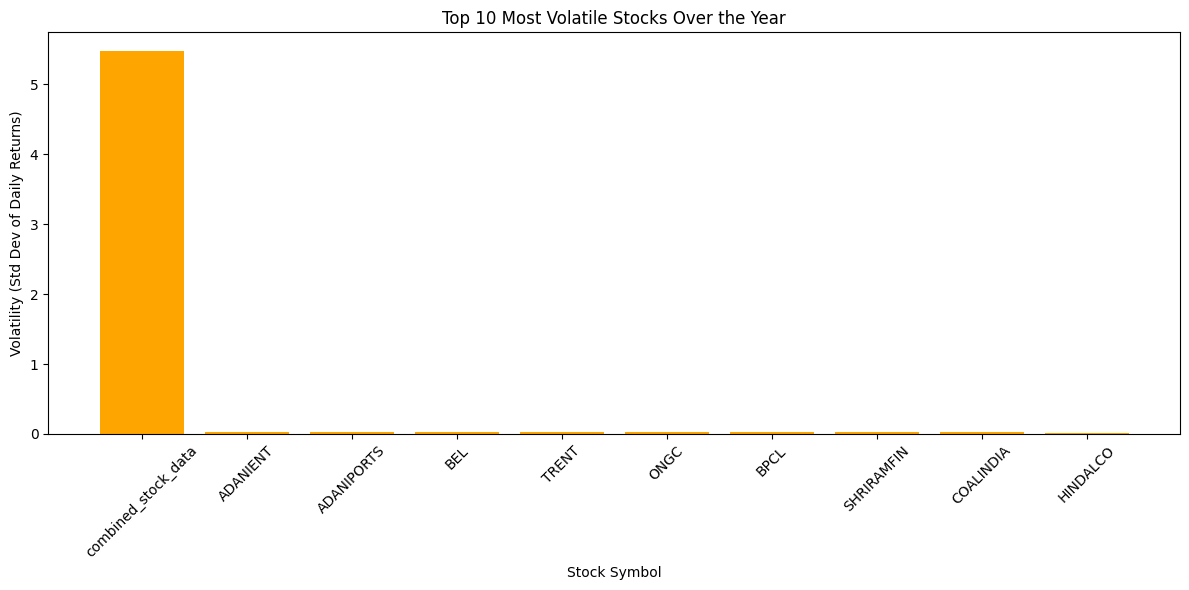

Bar chart saved to: D:\data-driven-stock-analysis\data\processed\top_10_volatile_stocks.png


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder where all processed stock CSVs are stored
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Dictionary to hold volatility values
volatility_dict = {}

# Loop through all CSV files in the processed folder
for file in os.listdir(processed_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(processed_folder, file)
        symbol = file.replace(".csv", "")

        try:
            df = pd.read_csv(file_path)

            if 'date' not in df.columns or 'close' not in df.columns:
                print(f"Skipping {symbol} — 'date' or 'close' column missing.")
                continue

            df = df[['date', 'close']].copy()
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df = df.dropna(subset=['date', 'close'])
            df = df.sort_values('date')

            # Calculate daily returns
            df['daily_return'] = df['close'].pct_change()
            volatility = df['daily_return'].std()

            if pd.notna(volatility):
                volatility_dict[symbol] = volatility

        except Exception as e:
            print(f"Error processing {symbol}: {e}")

# Convert to DataFrame
vol_df = pd.DataFrame(list(volatility_dict.items()), columns=['Symbol', 'Volatility'])
vol_df = vol_df.sort_values(by='Volatility', ascending=False).head(10)

# Save CSV
volatility_csv_path = os.path.join(processed_folder, "top_10_volatile_stocks.csv")
vol_df.to_csv(volatility_csv_path, index=False)
print(f"Top 10 volatile stocks saved to: {volatility_csv_path}")

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(vol_df['Symbol'], vol_df['Volatility'], color='orange')
plt.xlabel('Stock Symbol')
plt.ylabel('Volatility (Std Dev of Daily Returns)')
plt.title('Top 10 Most Volatile Stocks Over the Year')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(processed_folder, "top_10_volatile_stocks.png")
plt.savefig(plot_path)
plt.show()

print(f"Bar chart saved to: {plot_path}")


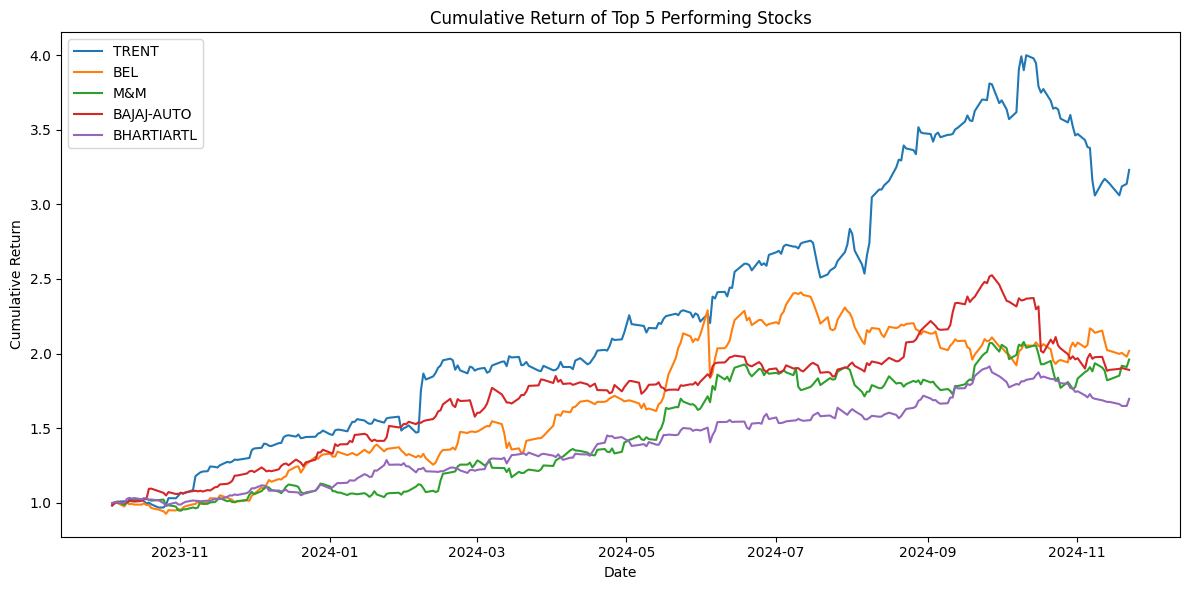

Cumulative return chart saved at: D:\data-driven-stock-analysis\data\processed\top_5_cumulative_returns.png
Cumulative return CSV saved at: D:\data-driven-stock-analysis\data\processed\top_5_cumulative_returns.csv


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define processed folder
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Dictionary to hold DataFrames of cumulative returns
cumulative_returns = {}
final_returns = {}

# Loop through each stock CSV file
for file in os.listdir(processed_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(processed_folder, file)
        symbol = file.replace(".csv", "")

        try:
            df = pd.read_csv(file_path)

            if 'date' not in df.columns or 'close' not in df.columns:
                continue

            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df = df.dropna(subset=['date', 'close'])
            df = df.sort_values('date')

            # Calculate daily return
            df['daily_return'] = df['close'].pct_change()

            # Calculate cumulative return
            df['cumulative_return'] = (1 + df['daily_return']).cumprod()

            # Store cumulative return with date
            cumulative_returns[symbol] = df[['date', 'cumulative_return']].dropna()

            # Save final cumulative return
            final_return = df['cumulative_return'].iloc[-1] if not df['cumulative_return'].isna().all() else 0
            final_returns[symbol] = final_return

        except Exception as e:
            print(f"Error in {symbol}: {e}")

# Convert final return dict to DataFrame
final_df = pd.DataFrame(list(final_returns.items()), columns=['Symbol', 'FinalCumulativeReturn'])
final_df = final_df.sort_values(by='FinalCumulativeReturn', ascending=False)

# Get top 5 symbols
top_5_symbols = final_df.head(5)['Symbol'].tolist()

# Plot cumulative return for top 5
plt.figure(figsize=(12, 6))
for symbol in top_5_symbols:
    data = cumulative_returns[symbol]
    plt.plot(data['date'], data['cumulative_return'], label=symbol)

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return of Top 5 Performing Stocks")
plt.legend()
plt.tight_layout()

# Save plot
plot_path = os.path.join(processed_folder, "top_5_cumulative_returns.png")
plt.savefig(plot_path)
plt.show()
print(f"Cumulative return chart saved at: {plot_path}")

# Save CSV for top 5 cumulative returns (merged for inspection)
combined_df = pd.DataFrame()
for symbol in top_5_symbols:
    temp_df = cumulative_returns[symbol].copy()
    temp_df = temp_df.rename(columns={"cumulative_return": symbol})
    if combined_df.empty:
        combined_df = temp_df
    else:
        combined_df = pd.merge(combined_df, temp_df, on='date', how='outer')

# Sort by date and save
combined_df = combined_df.sort_values('date')
csv_path = os.path.join(processed_folder, "top_5_cumulative_returns.csv")
combined_df.to_csv(csv_path, index=False)
print(f"Cumulative return CSV saved at: {csv_path}")


In [6]:
import pandas as pd

data = {
    'symbol': ['RELIANCE', 'TCS', 'INFY', 'HDFCBANK', 'ICICIBANK', 'HINDUNILVR', 'LT', 'BHARTIARTL', 'ITC', 'KOTAKBANK'],
    'sector': ['Energy', 'IT', 'IT', 'Financials', 'Financials', 'Consumer Goods', 'Infrastructure', 'Telecom', 'Consumer Goods', 'Financials']
}

sector_df = pd.DataFrame(data)
sector_df.to_csv(r'D:\data-driven-stock-analysis\data\sector_data.csv', index=False)

print(" Sector file created successfully.")


 Sector file created successfully.


 Sector returns calculated. Plotting bar chart...


C:\Users\ALDO\AppData\Local\Temp\ipykernel_32816\3633468608.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_returns, x='sector', y='yearly_return', palette='coolwarm')


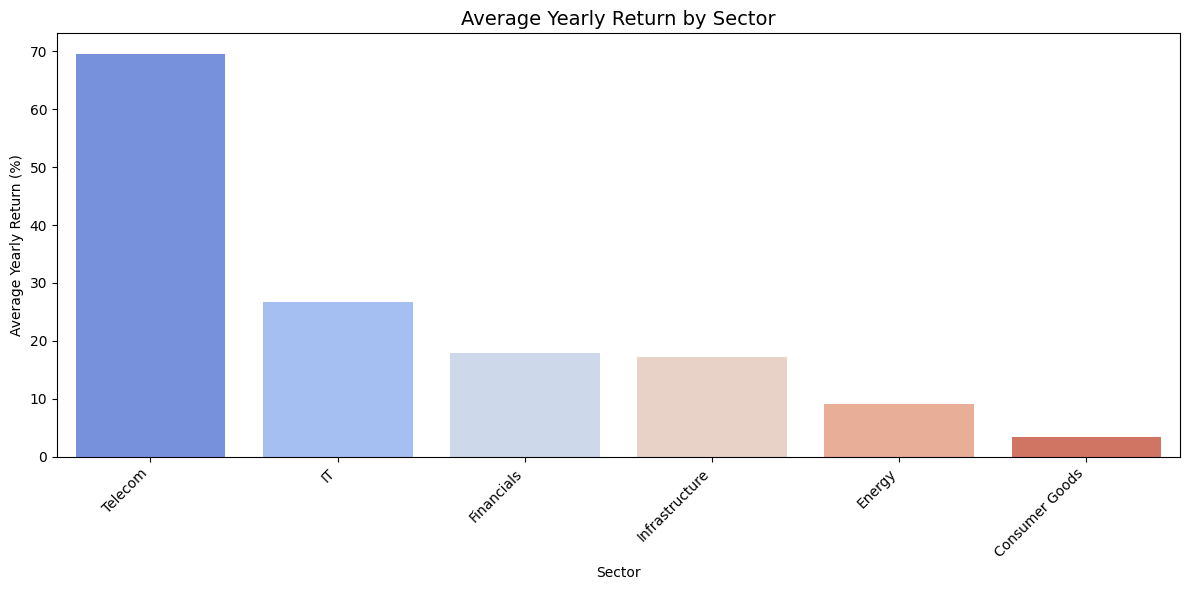

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
data_dir = r'D:\data-driven-stock-analysis\data\processed'
sector_file = r'D:\data-driven-stock-analysis\data\sector_data.csv' 
output_csv = os.path.join(data_dir, 'sector_wise_returns.csv')

# 1. Load Sector Mapping
if not os.path.exists(sector_file):
    print(f" Sector file not found: {sector_file}")
    sector_df = None
else:
    sector_df = pd.read_csv(sector_file)
    sector_df.columns = sector_df.columns.str.strip().str.lower()
    sector_df = sector_df[['symbol', 'sector']]
    sector_df['symbol'] = sector_df['symbol'].str.upper().str.replace('.NS', '', regex=False)

# 2. Compute Returns per Symbol
returns = []

for file in os.listdir(data_dir):
    if file.endswith('.csv') and file != 'sector_wise_returns.csv':
        symbol = file.replace('.csv', '').upper().replace('.NS', '')  # Clean symbol
        try:
            df = pd.read_csv(os.path.join(data_dir, file))
            if 'close' in df.columns and 'date' in df.columns:
                df = df[df['close'].notna()].sort_values(by='date')
                if len(df) >= 2:
                    start_price = df.iloc[0]['close']
                    end_price = df.iloc[-1]['close']
                    yearly_return = ((end_price - start_price) / start_price) * 100
                    returns.append({'symbol': symbol, 'yearly_return': yearly_return})
        except Exception as e:
            print(f"Error processing {symbol}: {e}")

returns_df = pd.DataFrame(returns)

# 3. Merge and Analyze Sector Returns
if sector_df is not None and not returns_df.empty:
    merged = pd.merge(returns_df, sector_df, on='symbol', how='inner')
    
    if not merged.empty:
        sector_returns = merged.groupby('sector')['yearly_return'].mean().reset_index()
        sector_returns = sector_returns.sort_values(by='yearly_return', ascending=False)
        sector_returns.to_csv(output_csv, index=False)

        print(" Sector returns calculated. Plotting bar chart...")

        plt.figure(figsize=(12, 6))
        sns.barplot(data=sector_returns, x='sector', y='yearly_return', palette='coolwarm')
        plt.title('Average Yearly Return by Sector', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Average Yearly Return (%)')
        plt.xlabel('Sector')
        plt.tight_layout()
        plt.show()
    else:
        print("No matching symbols between return data and sector file. Check symbol formats.")
else:
    print("Either sector file missing or return data is empty.")


C:\Users\ALDO\AppData\Local\Temp\ipykernel_36384\1970603297.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='monthly_return', y='symbol', palette='Greens_r')
C:\Users\ALDO\AppData\Local\Temp\ipykernel_36384\1970603297.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='monthly_return', y='symbol', palette='Reds')
C:\Users\ALDO\AppData\Local\Temp\ipykernel_36384\1970603297.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='monthly_return', y='symbol', palette='Greens_r')
C:\Users\ALDO\AppDat

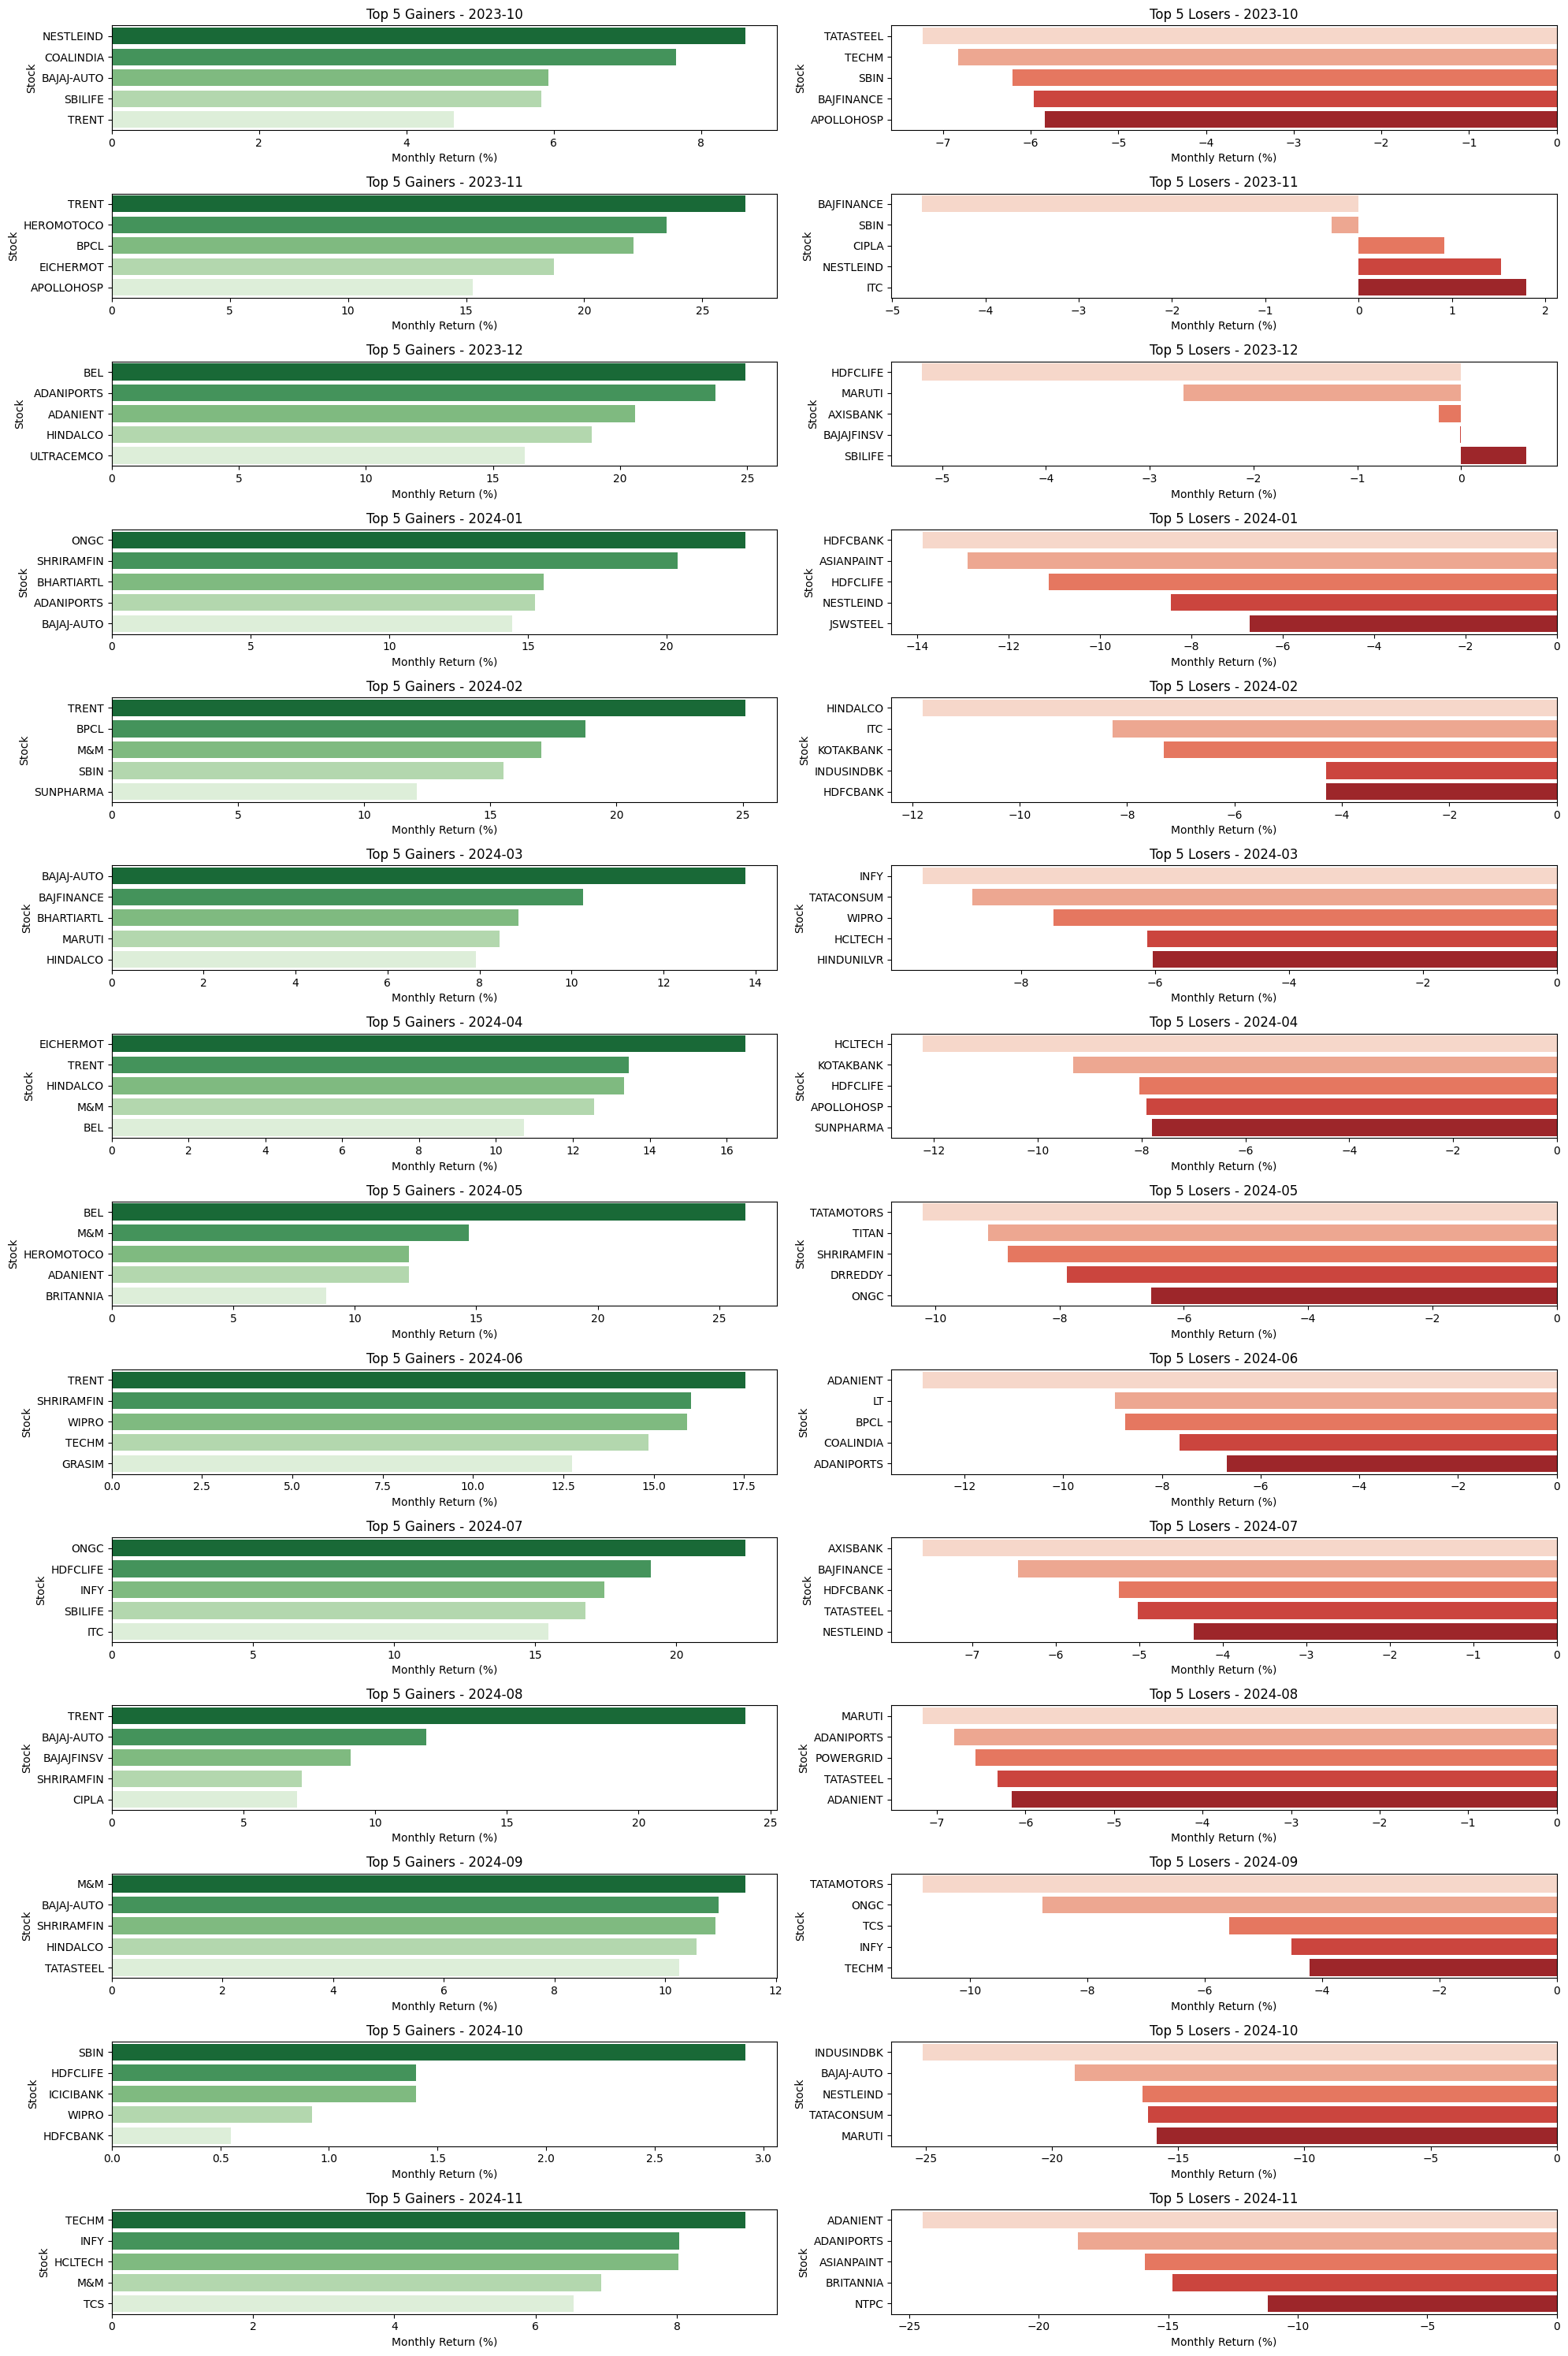

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
data_dir = r'D:\data-driven-stock-analysis\data\processed'

# Collect monthly returns for each stock
monthly_returns_list = []

for file in os.listdir(data_dir):
    if file.endswith('.csv') and file != 'sector_wise_returns.csv':
        symbol = file.replace('.csv', '').upper().replace('.NS', '')
        file_path = os.path.join(data_dir, file)
        
        try:
            df = pd.read_csv(file_path)
            if 'date' in df.columns and 'close' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df = df[['date', 'close']].dropna()
                df = df.sort_values('date')
                df['month'] = df['date'].dt.to_period('M')
                grouped = df.groupby('month')

                for month, group in grouped:
                    if len(group) >= 2:
                        start_price = group.iloc[0]['close']
                        end_price = group.iloc[-1]['close']
                        monthly_return = ((end_price - start_price) / start_price) * 100
                        monthly_returns_list.append({
                            'month': str(month),
                            'symbol': symbol,
                            'monthly_return': monthly_return
                        })
        except Exception as e:
            print(f"Error processing {symbol}: {e}")

# Create DataFrame
monthly_returns_df = pd.DataFrame(monthly_returns_list)

# Ensure months are sorted properly
monthly_returns_df['month'] = pd.to_datetime(monthly_returns_df['month'])

# Set up plots
months_sorted = sorted(monthly_returns_df['month'].dt.strftime('%Y-%m').unique())
plt.figure(figsize=(20, 30))
plot_idx = 1

for month_str in months_sorted:
    month_data = monthly_returns_df[monthly_returns_df['month'].dt.strftime('%Y-%m') == month_str]
    
    # Top 5 gainers
    top5 = month_data.sort_values(by='monthly_return', ascending=False).head(5)
    
    # Top 5 losers
    bottom5 = month_data.sort_values(by='monthly_return').head(5)

    # Plot Gainers
    plt.subplot(len(months_sorted), 2, plot_idx)
    sns.barplot(data=top5, x='monthly_return', y='symbol', palette='Greens_r')
    plt.title(f'Top 5 Gainers - {month_str}')
    plt.xlabel('Monthly Return (%)')
    plt.ylabel('Stock')
    plot_idx += 1

    # Plot Losers
    plt.subplot(len(months_sorted), 2, plot_idx)
    sns.barplot(data=bottom5, x='monthly_return', y='symbol', palette='Reds')
    plt.title(f'Top 5 Losers - {month_str}')
    plt.xlabel('Monthly Return (%)')
    plt.ylabel('Stock')
    plot_idx += 1

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Step 1: Define the input and output file paths
input_path = "D:/data-driven-stock-analysis/data/Sector_data - Sheet1.csv"
output_path = "D:/data-driven-stock-analysis/data/sector_mapping.csv"

# Step 2: Load the raw sector mapping file
raw_df = pd.read_csv(input_path)

# Step 3: Strip whitespace and convert column names to lowercase
raw_df.columns = raw_df.columns.str.strip().str.lower()

# Step 4: Print the cleaned column names for confirmation
print("✅ Cleaned columns:", raw_df.columns.tolist())

# Step 5: Try to extract only the necessary columns
if 'symbol' in raw_df.columns and 'sector' in raw_df.columns:
    sector_df = raw_df[['symbol', 'sector']].copy()

    # Step 6: Drop rows with missing values in symbol or sector
    sector_df.dropna(subset=['symbol', 'sector'], inplace=True)

    # Step 7: Save the cleaned mapping file
    sector_df.to_csv(output_path, index=False)
    print(f"✅ sector_mapping.csv saved to: {output_path}")
else:
    print("❌ 'symbol' or 'sector' columns not found in CSV.")


✅ Cleaned columns: ['company', 'sector', 'symbol']
✅ sector_mapping.csv saved to: D:/data-driven-stock-analysis/data/sector_mapping.csv


In [ ]:
import os
import pandas as pd
from sqlalchemy import create_engine

# DB config
username = "root"
password = 9618172007
host = "localhost"
port = 3306
database = "stock_analysis"
engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

# Folder where your processed CSVs are stored
data_folder = "d:/data-driven-stock-analysis/data/processed"  # change if different
all_data = []

# Read all CSVs and combine
for file in os.listdir(data_folder):
    if file.endswith(".csv") and not file.startswith("sector_"):
        df = pd.read_csv(os.path.join(data_folder, file))
        df['symbol'] = file.replace('.csv', '').upper()
        all_data.append(df)

# Combine all into one DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Drop duplicate column 'Symbol' if present
if 'Symbol' in final_df.columns:
    final_df = final_df.drop(columns=['Symbol'])

# Upload to MySQL
final_df.to_sql("stocks_2024", engine, if_exists="replace", index=False)

print("All stock data uploaded to MySQL table `stocks_2024`.")


All stock data uploaded to MySQL table `stocks_2024`.


In [ ]:
import pandas as pd

# Load your sector mapping file
df = pd.read_csv("D:/data-driven-stock-analysis/data/Sector_data - Sheet1.csv")

# Split the 'Symbol' column (format: "Company: Ticker")
df[['Company_clean', 'Ticker']] = df['Symbol'].str.split(':', expand=True)

# Clean extra spaces
df['Company_clean'] = df['Company_clean'].str.strip()
df['Ticker'] = df['Ticker'].str.strip()

# Drop old 'Symbol' column
df = df.drop(columns=['Symbol'])

# Rename columns properly
df = df.rename(columns={'COMPANY': 'Company', 'sector': 'Sector', 'Company_clean': 'Company'})

# Save cleaned file
df.to_csv("Sector_Mapping_Cleaned.csv", index=False)

print("Cleaned Sector Mapping file saved as 'Sector_Mapping_Cleaned.csv'")


Cleaned Sector Mapping file saved as 'Sector_Mapping_Cleaned.csv'


In [ ]:
import os
print(os.getcwd())  # shows current working directory



d:\data-driven-stock-analysis\scripts\calculate_metrics.py


In [ ]:
df.to_csv("filename.csv", index=False)


In [ ]:
import os
import pandas as pd

# Replace this with your actual folder path
folder_path = r"D:/data-driven-stock-analysis/data/processed"

# Create an empty list to hold all dataframes
all_dataframes = []

# Loop through all CSV files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):  # only CSV files
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        all_dataframes.append(df)

# Combine all into one DataFrame
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Save combined CSV
combined_df.to_csv("D:/data-driven-stock-analysis/data/processed/combined_stock_data.csv", index=False)

print("✅ Combined CSV created successfully!")


✅ Combined CSV created successfully!


In [9]:
# Check for null values in the dataset

# Column-wise null counts
print("Null values per column:\n", df.isnull().sum())

# Total nulls in the entire dataset
print("\nTotal null values in dataset:", df.isnull().sum().sum())

# Percentage of null values per column
print("\nPercentage of null values per column:\n", (df.isnull().mean() * 100))


Null values per column:
 date          0
close         0
pct_change    1
dtype: int64

Total null values in dataset: 1

Percentage of null values per column:
 date          0.000000
close         0.000000
pct_change    0.352113
dtype: float64


In [16]:
import pandas as pd
import glob
import os

# Path where all your stock CSV files are stored
path = "D:/data-driven-stock-analysis/data/processed"
all_files = glob.glob(os.path.join(path, "*.csv"))

dfs = []
excluded_files = ["combined_stock_data.csv", "sector_wise_returns.csv",
                  "top_10_gainers.csv", "top_10_losers.csv",
                  "top_10_volatile_stocks.csv", "top_5_cumulative_returns.csv"]

if not all_files:
    print(f" No CSV files found in directory: {path}")
else:
    print(f" Found {len(all_files)} CSV files in {path}")
    for file in all_files:
        filename = os.path.basename(file)
        if filename in excluded_files:
            print(f" Skipping {filename} (summary file)")
            continue

        try:
            df = pd.read_csv(file)

            if df.empty:
                print(f" Skipping empty file: {filename}")
                continue

            # Normalize column names
            df.columns = [c.strip().lower() for c in df.columns]

            # Add stock name
            stock_name = filename.replace(".csv", "")
            df["stock"] = stock_name

            dfs.append(df)
            print(f" Loaded: {filename} (rows: {len(df)})")

        except Exception as e:
            print(f" Error reading {filename}: {e}")

    if dfs:
        # Merge all stock files
        final_df = pd.concat(dfs, ignore_index=True)

        # Keep only useful columns
        keep_cols = ["date", "open", "high", "low", "close", "volume", "stock"]
        final_df = final_df[[c for c in keep_cols if c in final_df.columns]]

        # Clean data
        final_df.drop_duplicates(inplace=True)
        final_df.dropna(subset=["date", "close"], inplace=True)

        # Convert date
        final_df["date"] = pd.to_datetime(final_df["date"], errors="coerce")

        # Fix volume type
        if "volume" in final_df.columns:
            final_df["volume"] = (
                final_df["volume"]
                .astype(str)
                .replace({',': ''}, regex=True)
            )
            final_df["volume"] = pd.to_numeric(final_df["volume"], errors="coerce")

        # Save clean final CSV
        output_file = "final_stock_data.csv"
        final_df.to_csv(output_file, index=False)

        print(f"\n Final clean dataset created: {output_file}")
        print(" Shape:", final_df.shape)
        print(final_df.head())
    else:
        print(" No valid stock files to merge.")


 Found 56 CSV files in D:/data-driven-stock-analysis/data/processed
 Loaded: ADANIENT.csv (rows: 284)
 Loaded: ADANIPORTS.csv (rows: 284)
 Loaded: APOLLOHOSP.csv (rows: 284)
 Loaded: ASIANPAINT.csv (rows: 284)
 Loaded: AXISBANK.csv (rows: 284)
 Loaded: BAJAJ-AUTO.csv (rows: 284)
 Loaded: BAJAJFINSV.csv (rows: 284)
 Loaded: BAJFINANCE.csv (rows: 284)
 Loaded: BEL.csv (rows: 284)
 Loaded: BHARTIARTL.csv (rows: 284)
 Loaded: BPCL.csv (rows: 284)
 Loaded: BRITANNIA.csv (rows: 284)
 Loaded: CIPLA.csv (rows: 284)
 Loaded: COALINDIA.csv (rows: 284)
 Skipping combined_stock_data.csv (summary file)
 Loaded: DRREDDY.csv (rows: 284)
 Loaded: EICHERMOT.csv (rows: 284)
 Loaded: GRASIM.csv (rows: 284)
 Loaded: HCLTECH.csv (rows: 284)
 Loaded: HDFCBANK.csv (rows: 284)
 Loaded: HDFCLIFE.csv (rows: 284)
 Loaded: HEROMOTOCO.csv (rows: 284)
 Loaded: HINDALCO.csv (rows: 284)
 Loaded: HINDUNILVR.csv (rows: 284)
 Loaded: ICICIBANK.csv (rows: 284)
 Loaded: INDUSINDBK.csv (rows: 284)
 Loaded: INFY.csv (rows: 

In [1]:
import pandas as pd

# Load your raw sector file
file_path = r"D:\data-driven-stock-analysis\data\Sector_data - Sheet1.csv"
df = pd.read_csv(file_path)

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Make sure columns are 'symbol' and 'sector'
# (adjust if your file has slightly different names)
if "symbol" not in df.columns or "sector" not in df.columns:
    print("Available columns:", df.columns)
    raise ValueError("File must contain 'symbol' and 'sector' columns.")

# Clean data
df["symbol"] = df["symbol"].str.strip().str.upper()
df["sector"] = df["sector"].str.strip()

# Save cleaned mapping
output_path = r"D:\data-driven-stock-analysis\data\sector_mapping.csv"
df.to_csv(output_path, index=False)

print(f"✅ Cleaned sector mapping saved at: {output_path}")


✅ Cleaned sector mapping saved at: D:\data-driven-stock-analysis\data\sector_mapping.csv


In [4]:
import pandas as pd
import glob
import os

# Path where processed CSVs are saved
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Collect all CSV files
csv_files = glob.glob(os.path.join(processed_folder, "*.csv"))

# Merge into one DataFrame
all_data = []
for f in csv_files:
    df = pd.read_csv(f)
    all_data.append(df)

all_prices = pd.concat(all_data, ignore_index=True)

# Save to data folder
output_file = r"D:\data-driven-stock-analysis\data\all_prices.csv"
all_prices.to_csv(output_file, index=False)

print(f"✅ Combined file saved at: {output_file}")


✅ Combined file saved at: D:\data-driven-stock-analysis\data\all_prices.csv


In [6]:
import pandas as pd
import glob
import os

# Path where processed CSVs are saved
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Collect all CSV files
csv_files = glob.glob(os.path.join(processed_folder, "*.csv"))

# Merge into one DataFrame
all_data = []
for f in csv_files:
    df = pd.read_csv(f)
    all_data.append(df)

all_prices = pd.concat(all_data, ignore_index=True)

# Save to data folder
output_file = r"D:\data-driven-stock-analysis\data\all_prices.csv"
all_prices.to_csv(output_file, index=False)

print(f"✅ Combined file saved at: {output_file}")


✅ Combined file saved at: D:\data-driven-stock-analysis\data\all_prices.csv


In [7]:
import pandas as pd
import glob
import os

# Paths
processed_folder = r"D:\data-driven-stock-analysis\data\processed"
output_file = r"D:\data-driven-stock-analysis\data\all_prices.csv"

# Files to exclude (summary/derived)
excluded_files = [
    "combined_stock_data.csv",
    "sector_wise_returns.csv",
    "top_10_gainers.csv",
    "top_10_losers.csv",
    "top_10_volatile_stocks.csv",
    "top_5_cumulative_returns.csv",
    "final_stock_data.csv",
    "all_prices.csv"
]

# Collect CSV files
csv_files = glob.glob(os.path.join(processed_folder, "*.csv"))
all_data = []

for f in csv_files:
    filename = os.path.basename(f)
    if filename in excluded_files:
        print(f"⏩ Skipping summary file: {filename}")
        continue

    try:
        df = pd.read_csv(f)
        if df.empty:
            print(f"⚠️ Skipping empty file: {filename}")
            continue

        # Standardize columns
        df.columns = df.columns.str.strip().str.lower()

        # Keep only needed columns
        keep_cols = ["date", "open", "high", "low", "close", "volume"]
        df = df[[c for c in keep_cols if c in df.columns]]

        # Add stock symbol from filename
        symbol = filename.replace(".csv", "").upper().replace(".NS", "")
        df["symbol"] = symbol

        # Convert date column
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

        # Clean volume
        if "volume" in df.columns:
            df["volume"] = (
                df["volume"].astype(str).str.replace(",", "", regex=True)
            )
            df["volume"] = pd.to_numeric(df["volume"], errors="coerce")

        # Sort by date & calculate returns
        df = df.sort_values("date").reset_index(drop=True)
        df["prev_close"] = df["close"].shift(1)
        df["daily_return"] = ((df["close"] - df["prev_close"]) / df["prev_close"]) * 100

        all_data.append(df)
        print(f"✅ Loaded: {filename} (rows: {len(df)})")

    except Exception as e:
        print(f"❌ Error reading {filename}: {e}")

# Combine all data
if all_data:
    all_prices = pd.concat(all_data, ignore_index=True)

    # Final clean
    all_prices.dropna(subset=["date", "close"], inplace=True)

    # Save
    all_prices.to_csv(output_file, index=False)
    print(f"\n🎯 Final all_prices.csv created successfully at: {output_file}")
    print("Shape:", all_prices.shape)
    print(all_prices.head())
else:
    print("❌ No valid stock CSVs found to combine.")


✅ Loaded: ADANIENT.csv (rows: 284)
✅ Loaded: ADANIPORTS.csv (rows: 284)
✅ Loaded: APOLLOHOSP.csv (rows: 284)
✅ Loaded: ASIANPAINT.csv (rows: 284)
✅ Loaded: AXISBANK.csv (rows: 284)
✅ Loaded: BAJAJ-AUTO.csv (rows: 284)
✅ Loaded: BAJAJFINSV.csv (rows: 284)
✅ Loaded: BAJFINANCE.csv (rows: 284)
✅ Loaded: BEL.csv (rows: 284)
✅ Loaded: BHARTIARTL.csv (rows: 284)
✅ Loaded: BPCL.csv (rows: 284)
✅ Loaded: BRITANNIA.csv (rows: 284)
✅ Loaded: CIPLA.csv (rows: 284)
✅ Loaded: COALINDIA.csv (rows: 284)
⏩ Skipping summary file: combined_stock_data.csv
✅ Loaded: DRREDDY.csv (rows: 284)
✅ Loaded: EICHERMOT.csv (rows: 284)
✅ Loaded: GRASIM.csv (rows: 284)
✅ Loaded: HCLTECH.csv (rows: 284)
✅ Loaded: HDFCBANK.csv (rows: 284)
✅ Loaded: HDFCLIFE.csv (rows: 284)
✅ Loaded: HEROMOTOCO.csv (rows: 284)
✅ Loaded: HINDALCO.csv (rows: 284)
✅ Loaded: HINDUNILVR.csv (rows: 284)
✅ Loaded: ICICIBANK.csv (rows: 284)
✅ Loaded: INDUSINDBK.csv (rows: 284)
✅ Loaded: INFY.csv (rows: 284)
✅ Loaded: ITC.csv (rows: 284)
✅ Loade

In [10]:
import pandas as pd

# Load combined stock data
df = pd.read_csv(r"D:\data-driven-stock-analysis\data\all_prices.csv")

# Normalize column names
df.columns = df.columns.str.strip().str.lower()
print("Columns found:", df.columns.tolist())

# Detect stock column
if "stock" in df.columns:
    stock_col = "stock"
elif "symbol" in df.columns:
    stock_col = "symbol"
else:
    raise KeyError("❌ Neither 'stock' nor 'symbol' column found in dataset.")

# Ensure required columns exist
required = ["date", stock_col, "close"]
for col in required:
    if col not in df.columns:
        raise KeyError(f"❌ Missing required column: {col}")

# Keep only required
df = df[required]

# Pivot so each stock becomes a column
pivot_df = df.pivot(index="date", columns=stock_col, values="close")

# Calculate daily returns
returns = pivot_df.pct_change()

# Correlation matrix
corr_matrix = returns.corr()

# Convert to long format
corr_long = corr_matrix.reset_index().melt(
    id_vars=stock_col, var_name="stock2", value_name="correlation"
)
corr_long = corr_long.rename(columns={stock_col: "stock1"})

# Save
output_path = r"D:\data-driven-stock-analysis\data\correlation_matrix.csv"
corr_long.to_csv(output_path, index=False)

print(f"✅ Correlation matrix saved at: {output_path}")


Columns found: ['date', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'prev_close', 'daily_return']
✅ Correlation matrix saved at: D:\data-driven-stock-analysis\data\correlation_matrix.csv


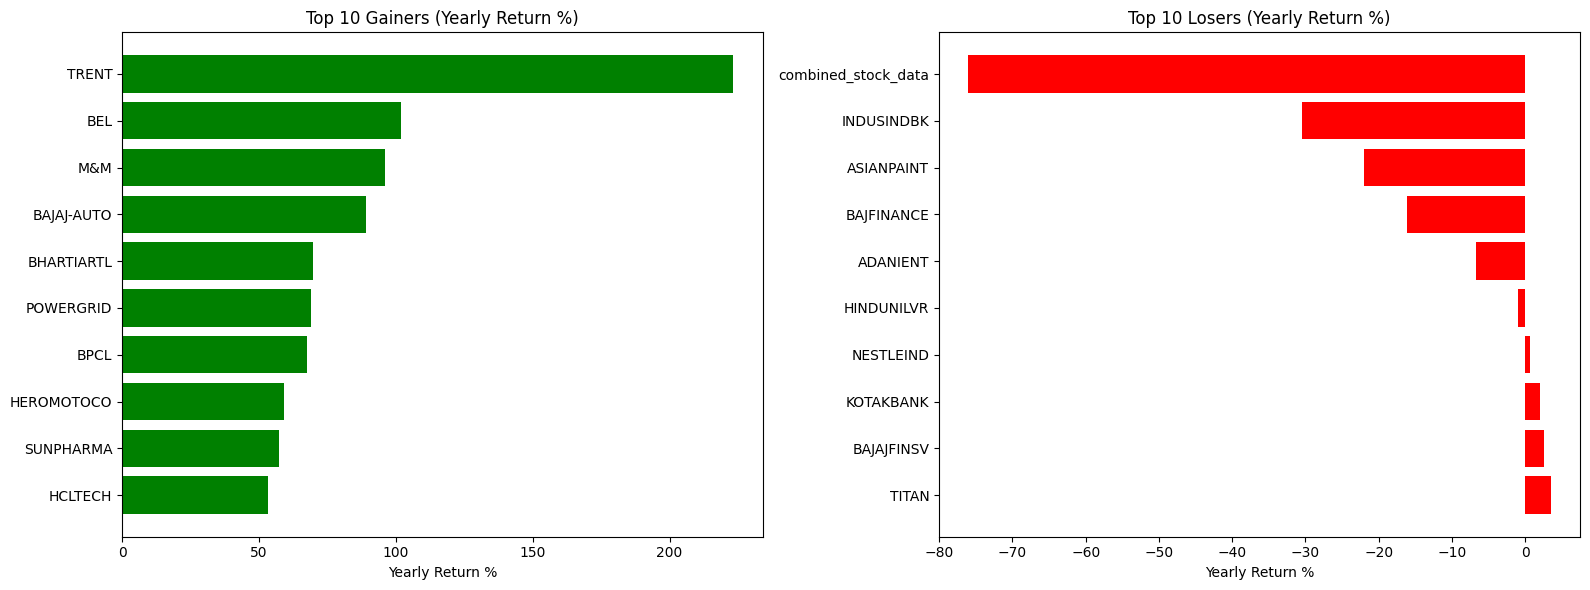

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path where gainers/losers CSVs were saved
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Load data
gainers_path = os.path.join(processed_folder, "top_10_gainers.csv")
losers_path = os.path.join(processed_folder, "top_10_losers.csv")

top_10_gainers = pd.read_csv(gainers_path)
top_10_losers = pd.read_csv(losers_path)

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gainers
axes[0].barh(top_10_gainers['symbol'], top_10_gainers['yearly_return_%'], color='green')
axes[0].set_title("Top 10 Gainers (Yearly Return %)")
axes[0].set_xlabel("Yearly Return %")
axes[0].invert_yaxis()  # Highest at top

# Losers
axes[1].barh(top_10_losers['symbol'], top_10_losers['yearly_return_%'], color='red')
axes[1].set_title("Top 10 Losers (Yearly Return %)")
axes[1].set_xlabel("Yearly Return %")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


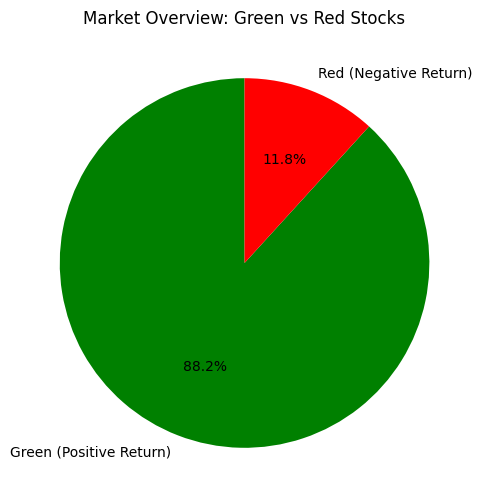

📊 Market Overview Summary
Average Stock Price: 2449.42
Average Volume: 6,833,475
Green Stocks: 45
Red Stocks: 6


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob

# Path to processed stock CSVs
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Read and combine all stock CSVs
all_files = glob(os.path.join(processed_folder, "*.csv"))
combined_data = []

for file in all_files:
    symbol = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)

        if "date" not in df.columns or "close" not in df.columns or "volume" not in df.columns:
            continue  # skip invalid files

        df["symbol"] = symbol
        combined_data.append(df)

    except Exception as e:
        print(f"Error reading {symbol}: {e}")

# Merge all data
df = pd.concat(combined_data, ignore_index=True)

# --- Market Summary Stats ---
avg_price = df["close"].mean()
avg_volume = df["volume"].mean()

# --- Green vs Red Stocks ---
returns_df = df.groupby("symbol").agg(
    start_price=("close", "first"),
    end_price=("close", "last")
).reset_index()

returns_df["return"] = returns_df["end_price"] - returns_df["start_price"]
returns_df["status"] = returns_df["return"].apply(lambda x: "Green" if x > 0 else "Red")

green_count = (returns_df["status"] == "Green").sum()
red_count = (returns_df["status"] == "Red").sum()

# --- Pie Chart ---
plt.figure(figsize=(6, 6))
plt.pie(
    [green_count, red_count],
    labels=["Green (Positive Return)", "Red (Negative Return)"],
    autopct="%1.1f%%",
    colors=["green", "red"],
    startangle=90
)
plt.title("Market Overview: Green vs Red Stocks")
plt.show()

# --- Print Summary Stats ---
print("📊 Market Overview Summary")
print(f"Average Stock Price: {avg_price:.2f}")
print(f"Average Volume: {avg_volume:,.0f}")
print(f"Green Stocks: {green_count}")
print(f"Red Stocks: {red_count}")
